In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score

from IPython.display import clear_output
from gc import collect
import warnings

warnings.simplefilter('ignore')

In [9]:
# voting model

class VotingModel(BaseEstimator, ClassifierMixin):
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)
    
    def predict_proba(self, X):
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

In [10]:
# files read

df_train = pd.read_csv('train_scaled.csv')
df_test = pd.read_csv('test_scaled.csv')

print('train data shape:', df_train.shape)
print('test data shape:', df_test.shape)

df_train, df_test = df_train.align(df_test, axis=1)

print('train data shape aligned:', df_train.shape)
print('test data shape aligned:', df_test.shape)

X = df_train.drop(columns='not.fully.paid')
y = df_train['not.fully.paid']

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train data shape: (40785, 20)
test data shape: (40786, 19)
train data shape aligned: (40785, 20)
test data shape aligned: (40786, 20)


In [11]:
# catboost

params_cat = {
    "iterations": 5000,
    "learning_rate": 0.05,
    "depth": 6,
    "eval_metric": "AUC",
    "random_seed": 42,
    "logging_level": "Verbose",
    "use_best_model": True,
    'loss_function': 'Logloss'
}

fitted_models_cat = []
scores_cat = []
oof_preds_cat = np.zeros(X.shape[0])

for idx_train, idx_valid in cv.split(X, y):
  
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    model_cat = CatBoostClassifier(**params_cat)
    model_cat.fit(
        X_train, y_train, 
        eval_set=(X_valid, y_valid), 
        early_stopping_rounds=200, verbose=100)
    
    pred_cat = model_cat.predict_proba(X_valid)[:, 1]
    score_cat = roc_auc_score(y_valid, pred_cat)
    
    scores_cat.append(score_cat)
    oof_preds_cat[idx_valid] = pred_cat
    fitted_models_cat.append(model_cat)
    
    clear_output()

cat_auc = roc_auc_score(y, oof_preds_cat)
scores_cat.append(cat_auc)
print(f'CatBoost AUC: {cat_auc:.6f}')

CatBoost AUC: 0.794010


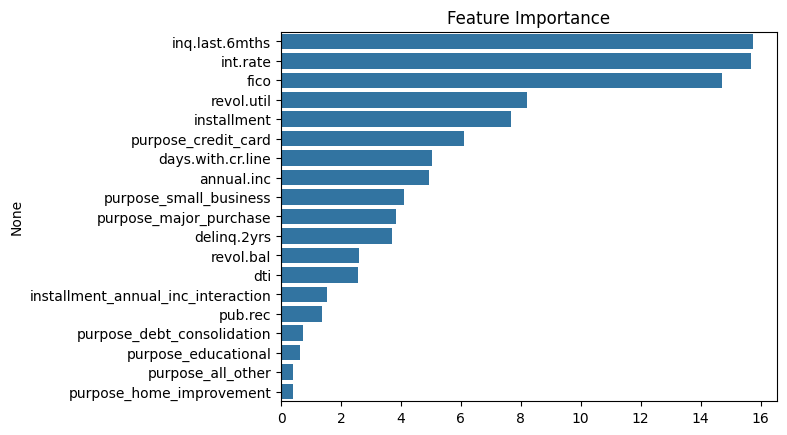

In [12]:
# importance

importance = model_cat.get_feature_importance()
features = X.columns
sorted_idx = np.argsort(importance)[::-1]

sns.barplot(x=importance[sorted_idx], y=features[sorted_idx])
plt.title('Feature Importance')
plt.show()

In [13]:
# voting catboost

voting_cat = VotingModel(estimators=fitted_models_cat)
scores_cat_df = pd.DataFrame({'CatBoost': scores_cat})

scores_cat_df

,CatBoost
0,0.793356
1,0.789996
2,0.805939
3,0.786251
4,0.795173
5,0.794010


In [14]:
# predict

X_test = df_test.drop(columns='not.fully.paid')
test_pred = voting_cat.predict_proba(X_test)[:, 1]

submit = pd.read_csv('sample_submission.csv', header=None)
submit[1] = test_pred

submit.to_csv('submission.csv', header=None, index=False)
print('Submission saved.')

Submission saved.
